In [1]:
# Imports

%matplotlib widget

import ipywidgets as widgets
import matplotlib.pyplot as plt
import math
import numpy as np
from numpy.fft import fft, ifft, fftshift, ifftshift
import scipy.signal as sc
import scipy.io.wavfile as sc_wav
import csv 
import pandas as pd


compararConTabla()

In [2]:
def compararConTabla(pitch, pitchTable):
    encontrado = 0

    if pitch <= pitchTable[0]:
        pitchCorrecto = pitchTable[0]
        encontrado = 1

    if encontrado == 0:
        if pitch > pitchTable[len(pitchTable)-1]:
            pitchCorrecto = pitchTable[len(pitchTable)-1]
            encontrado = 1
        
    i = 1
    while encontrado == 0:
        if pitch > pitchTable[i] and pitch <= pitchTable[i+1]:
            pitchCorrecto = pitchTable[i+1]
            encontrado = 1
        i = i+1

    return pitchCorrecto

autoCorrelacion()

In [3]:
def auto_corr(x,fm):

    T = 1/fm 
    pmin = 50
    pmax = 400

    Tmin = 1/pmax
    Tmax = 1/pmin

    nmin = int(math.floor(Tmin/T))
    nmax = int(math.ceil(Tmax/T))

    x_cor = np.correlate(x,x,mode='full')
    x_cor = x_cor[len(x):len(x_cor)]

    i = np.argmax(x_cor[nmin:nmax])

    nF0 = i+nmin
    T0 = nF0*T

    F0 = 1/T0

    return F0

estimarF0()

In [4]:
def estimarF0(signal, F0Ref):

    tvent = 0.032
    tstep = 0.005804988662131519

    tamanioVent = int(tvent*rate)
    nstep = int(tstep*rate)

    cantidadVentanasRef = len(F0Ref)
    #cantidadVentanasRef = int((len(signal)-tamanioVent-tamanioVent/2-nstep)/nstep)

    cantidadVentanasEstimacion = int((len(signal)/tamanioVent))
    vent = np.hanning(tamanioVent*2+1)
    vent = vent[np.arange(1,len(vent),2)]
    
    ini = tamanioVent//2
    F0Estimada = np.zeros(cantidadVentanasRef)

    # print(cantidadVentanasRef)
    # print(len(F0Estimada))
    for i in range(cantidadVentanasRef):
        if F0Ref[i]>0:
            F0Estimada[i] = auto_corr(signal[ini:ini + tamanioVent]*vent,rate)
        ini = ini + nstep


    treshold = 200
    for i in range(cantidadVentanasRef):
        if F0Estimada[i]>=treshold:
            F0Estimada[i] = F0Estimada[i-1]
            #for i in range(cantidadVentanasRef-1):  
            # if  abs(F0Estimada[i+1]-F0Estimada[i]) or abs(F0Estimada[i-1]-F0Estimada[i]) >=treshold:    
            #        if F0Estimada[i-1]!=0 and F0Estimada[i+1]!=0:
            #            F0Estimada[i]=F0Estimada[i-1]/2 + F0Estimada[i+1]/2
            #        else:
            #            F0Estimada[i]=0
    print(len(F0Estimada))
    return F0Estimada

Main de estimación y búsqueda en la tabla

In [5]:
rate, signal = sc_wav.read('dataset_proyecto/vocadito_1.wav')

ref_aux = pd.read_csv('dataset_proyecto/vocadito_1_f0.csv', names = ['f0','t'])

ref = []
for col in ref_aux:
    col_ref = ref_aux[col].tolist()
    ref.append(col_ref)

F0Ref = ref[1]
tRef = ref[0]

tvent = 0.032
tstep = 0.005804988662131519
tamanioVent = int(tvent*rate)
print('tamanio vent', tamanioVent)
nstep = int(tstep*rate)
print('paso',nstep)
cantidadVentanasRef = len(F0Ref)
print('cant vent',cantidadVentanasRef)
vent = np.hamming(tamanioVent)

#Estimacion de F0 usando autocorrelacion

F0Estimada = estimarF0(signal, F0Ref)

pitchTable=[0,16.352,17.324,18.354,19.445,20.602,21.827,23.125,24.500,25.957,27.500,29.135,
            30.868,32.703,34.648,36.708,38.891,41.203,43.654,46.249,48.999,51.913,55.000,58.270,
            61.735,65.406,69.296,73.416,77.782,82.407,87.307,92.499,97.999,103.830,110.000,
            116.540,123.470,130.800,138.590,146.830,155.560,164.810,174.610,185.000,196.000,
            207.650,220.000,233.080,246.940,261.630,277.180,293.660,311.130,329.630,349.230,
            369.990,392.000,415.300,440.000,466.160,493.880,523.250,554.370,587.330,622.250,
            659.260,698.460,739.990,783.990,830.610,880.000,932.330,987.770,1046.500,1108.700,
            1174.700,1244.500,1318.500,1396.900,1480.000,1568.000,1661.200,1760.000,1864.700,
            1975.500,2093.000,2217.500,2349.300,2489.000,2637.000,2793.800,2960.000,3136.000,
            3322.400,3520.000,3729.300,3951.100,4186.000,4434.900,4698.600,4978.000,5274.000,
            5587.700,5919.900,6271.900,6644.900,7040.000,7458.600,7902.100,8372.000,8869.800,
            9397.300,9956.100,10548.100,11175.300,11839.800,12543.900,13289.800,14080.000,
            14917.200,15804.300,16744.000,17739.700,18794.500,19912.100,21096.200,22350.600]

F0RefSegunTabla = np.zeros(len(F0Ref))

for i in range(len(F0Ref)-1):
    F0RefSegunTabla[i] = compararConTabla(F0Ref[i], pitchTable)

F0EstimadaSegunTabla = np.zeros(len(F0Estimada))
for i in range(len(F0Estimada)-1):
    F0EstimadaSegunTabla[i] = compararConTabla(F0Estimada[i], pitchTable)


tamanio vent 1411
paso 256
cant vent 5722
5722


Gráficos de estimación y búsqueda en la tabla

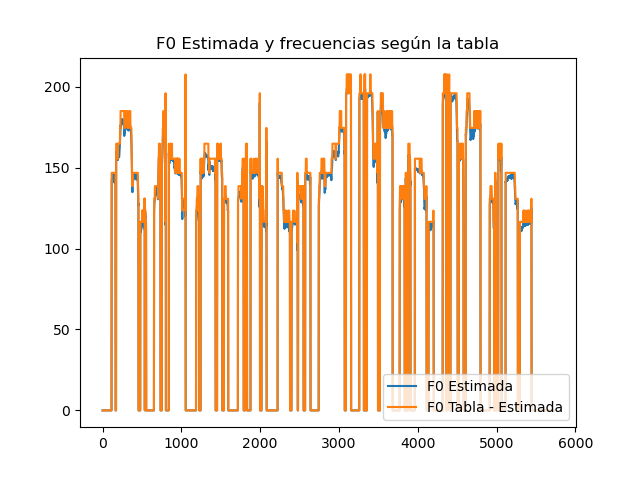

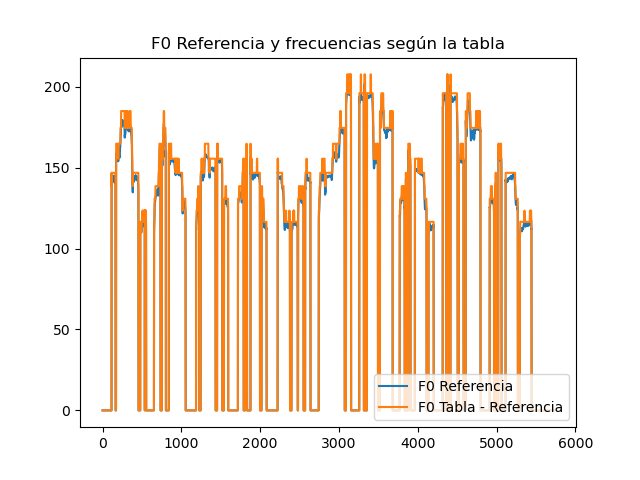

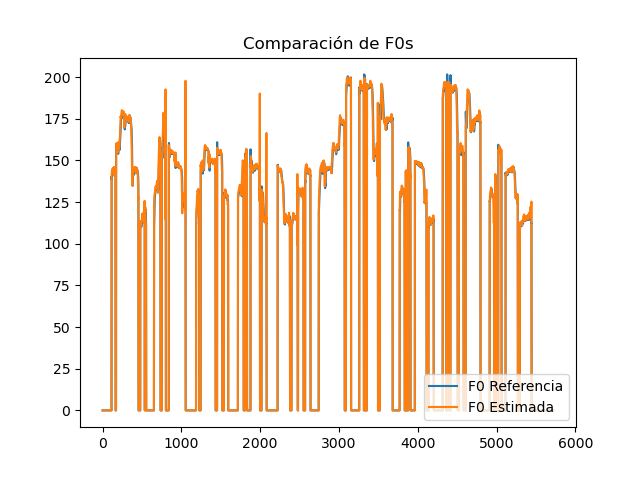

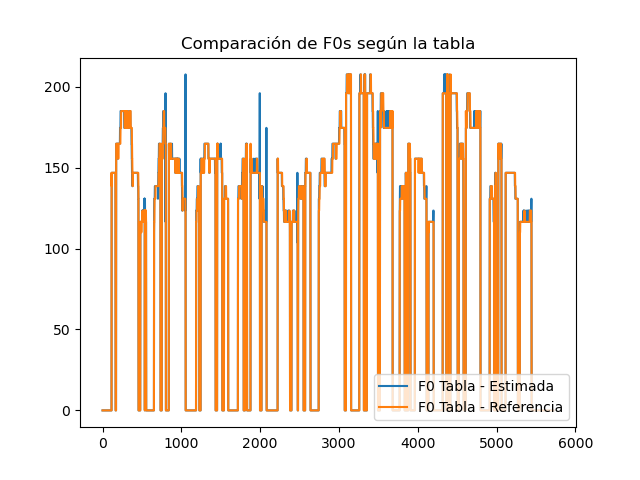

In [6]:
#GRAFICOS

#F0 estimada
fig, ax = plt.subplots()
ax.plot(F0Estimada, label = 'F0 Estimada')
ax.plot(F0EstimadaSegunTabla, label = 'F0 Tabla - Estimada')
legend = ax.legend(loc='lower right')
plt.title('F0 Estimada y frecuencias según la tabla')
plt.show()

#F0 referencia
fig, ax = plt.subplots()
ax.plot(F0Ref, label = 'F0 Referencia')
ax.plot(F0RefSegunTabla, label = 'F0 Tabla - Referencia')
legend = ax.legend(loc='lower right')
plt.title('F0 Referencia y frecuencias según la tabla')
plt.show()

#Comparación F0s
fig, ax = plt.subplots()
ax.plot(F0Ref, label = 'F0 Referencia')
ax.plot(F0Estimada, label = 'F0 Estimada')
legend = ax.legend(loc='lower right')
plt.title('Comparación de F0s')
plt.show()

#Comparación F0s según la tabla
fig, ax = plt.subplots()
ax.plot(F0EstimadaSegunTabla, label = 'F0 Tabla - Estimada')
ax.plot(F0RefSegunTabla, label = 'F0 Tabla - Referencia')
legend = ax.legend(loc='lower right')
plt.title('Comparación de F0s según la tabla')
plt.show()

Shift de STFT

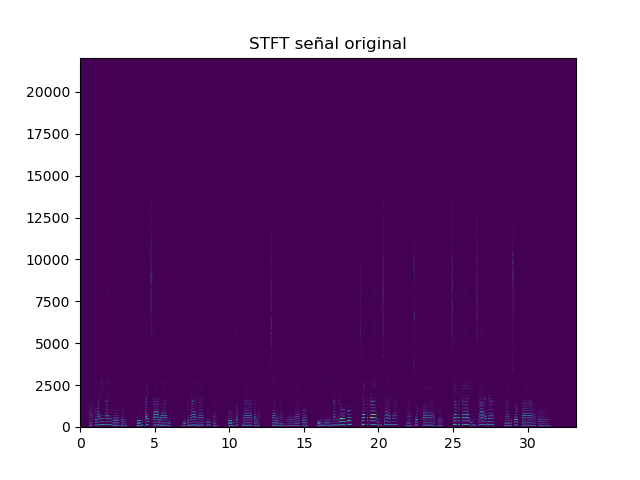

<ipython-input-7-2bad239286e9>:10: RuntimeWarning: invalid value encountered in true_divide
  ratio = F0EstimadaSegunTabla/F0Estimada


[1. 1. 1. ... 1. 1. 1.]


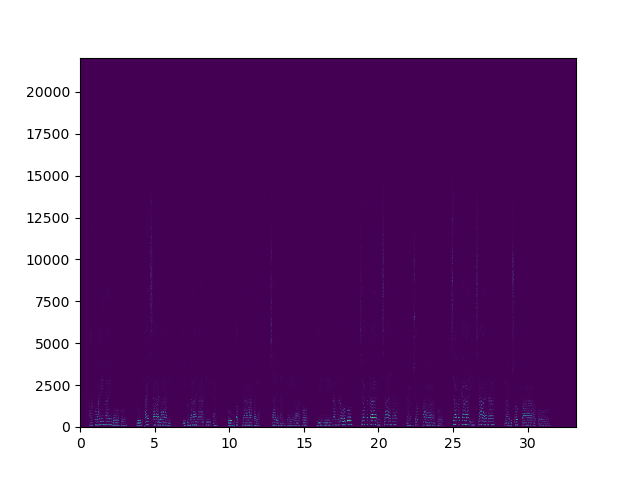

In [7]:
f, t, z = sc.stft(signal, rate, vent, nperseg = tamanioVent, noverlap = tamanioVent**0.75)

plt.figure()
plt.pcolormesh(t, f, abs(z), vmin = 0, shading='auto')
plt.title('STFT señal original')
plt.show()

pcorr2 = F0Estimada

ratio = F0EstimadaSegunTabla/F0Estimada
ratio[np.isnan(ratio)] = 1
S_corrected = np.zeros((len(f),len(t)))
print(ratio)
for k in range(len(t)):
    for j in range(len(f)):
        y = round(j/ratio[k])
          
        #Prevents negative indices
        if y < 1:
            y = 1
          
        #Non-constant frequency scaling
        if y <= len(f):
            S_corrected[j,k] = np.real(z[y,k])
          
        
plt.figure()
plt.pcolormesh(t, f, abs(S_corrected), vmin=0, shading='auto')
plt.show()
plt.title('STFT señal corregida')

t,signalCorregida = sc.istft(S_corrected, rate, vent, nperseg = tamanioVent, noverlap = tamanioVent**0.75)

Verificación del resultado obtenido

5722


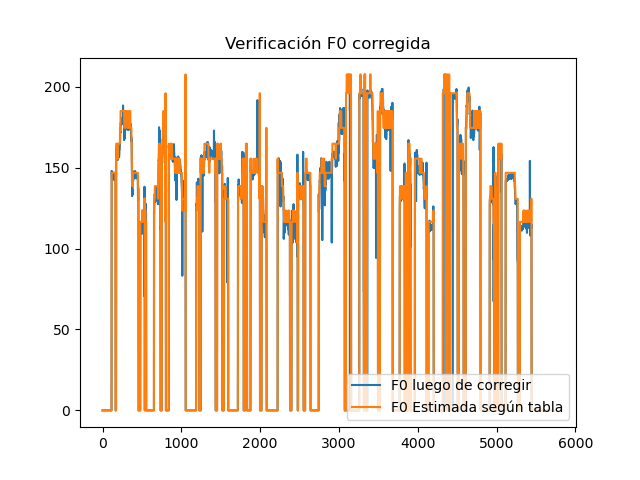

In [8]:
F0Corregida = estimarF0(signalCorregida, F0Ref)

fig, ax = plt.subplots()
ax.plot(F0Corregida, label = 'F0 luego de corregir')
ax.plot(F0EstimadaSegunTabla, label = 'F0 Estimada según tabla')
legend = ax.legend(loc='lower right')
plt.title('Verificación F0 corregida')
plt.show()

sc_wav.write('test_01.wav',rate,signalCorregida.astype(np.int16))
sc_wav.write('test_02.wav',rate,signal.astype(np.int16))
rate2, senal2 = sc_wav.read('test_01.wav')

In [9]:
def  createFrames(x, hop, windowSize):
    # Find the max number of slices that can be obtained
    numberSlices = math.floor((len(x)-windowSize)/hop)

    # Truncate if needed to get only a integer number of hop
    x = x[0:(numberSlices*hop+windowSize)]

    # Create a matrix with time slices
    vectorFrames = np.zeros((math.floor(len(x)/hop),windowSize))
    # Fill the matrix
    for index in range(numberSlices):
        indexTimeStart = (index)*hop
        indexTimeEnd = (index)*hop + windowSize
        
        vectorFrames[index,:] = x[indexTimeStart: indexTimeEnd]


    return vectorFrames,numberSlices

In [10]:
def fusionFrames(framesMatrix, hop):

    sizeMatrix = np.size(framesMatrix)

    # Get the number of frames
    numberFrames = len(framesMatrix)

    # Get the size of each frame
    sizeFrames = len(framesMatrix[0])

    # Define an empty vector to receive result
    
    timeIndex = 0
   
   
    vectorTime = np.zeros(numberFrames*hop-hop+sizeFrames)

    # Loop for each frame and overlap-add
    for index in range(numberFrames):
        vectorTime[timeIndex:timeIndex+sizeFrames] = vectorTime[timeIndex:timeIndex+sizeFrames] + framesMatrix[index,:]
        timeIndex = timeIndex + hop

    return vectorTime

In [17]:
def pitchShift(inputVector, windowSize, hopSize, step):
    ## Parameters
    
    # Window size
    winSize = windowSize
    # Space between windows
    hop = hopSize
    # math.pitch scaling factor
    ##alpha = 2^(step/12);
    alpha = step
    # Intermediate constants
    hopOut = round(alpha * hop)
    
    # Hanning window for overlap-add
    wn = np.hanning(winSize*2+1)
    
    wn = wn[np.arange(1,len(wn),2)]
    ## Source file
    
    x = inputVector
   
    # Rotate if needed

    x = np.concatenate((np.zeros((hop * 3)),x))
    
    ## Initialization
    
    # Create a frame matrix for the current input
    y,numberFramesInput = createFrames(x,hop,winSize)

    # Create a frame matrix to receive processed frames
    numberFramesOutput = numberFramesInput
    outputy = np.zeros((numberFramesOutput,winSize))
    
    # Initialize cumulative phase
    phaseCumulative = 0
    # Initialize previous frame phase
    previousPhase = 0
    for index in range(numberFramesInput):#np.arange(1,numberFramesInput+1).reshape(-1):
        ## Analysis
        # Get current frame to be processed
        currentFrame = y[index,:]
        
        
        # Window the frame
        currentFrameWindowed = np.multiply(currentFrame,wn) / np.sqrt(((winSize / hop) / 2))
     
        # Get the FFT
        currentFrameWindowedFFT = fft(currentFrameWindowed)
        # Get the magnitude
        magFrame = abs(currentFrameWindowedFFT)
        
        # Get the angle
        phaseFrame = np.angle(currentFrameWindowedFFT)

        ## Processing
        # Get the phase difference
        deltaPhi = phaseFrame - previousPhase
      
        previousPhase = phaseFrame
       
        # Remove the expected phase difference
        deltaPhiPrime = deltaPhi - hop * 2 * math.pi * (np.arange(0,(winSize - 1)+1)) / winSize
        
        # Map to -math.pi/math.pi range
        deltaPhiPrimeMod = np.mod(deltaPhiPrime + math.pi,2 * math.pi) - math.pi
       
        # Get the true frequency
        trueFreq = 2 * math.pi * (np.arange(0,(winSize - 1)+1)) / winSize + deltaPhiPrimeMod / hop
     
        # Get the final phase
        
        #PRUEBA
        alpha = ratio[index]
        hopOut = round(alpha * hop)

        phaseCumulative = phaseCumulative + hopOut * trueFreq
        
        # Remove the 60 Hz noise. This is not done for now but could be
# achieved by setting some bins to zero.
        ## Synthesis
        # Get the magnitude
        outputMag = magFrame
      
        # Produce output frame
        
        outputFrame = np.real(ifft(np.multiply(outputMag,np.exp(np.array([complex(0,i) for i in phaseCumulative])))))
     
        # Save frame that has been processed
        outputy[index,:] = np.multiply(outputFrame,np.transpose(wn)) / np.sqrt(((winSize / hopOut) / 2))
       
    
    ## Finalize
# Overlap add in a vector
    outputTimeStretched = fusionFrames(outputy,hopOut)
    
    ##
### Resample with linearinterpolation
   ## outputTime = np.interp((np.arange(0,(len(outputTimeStretched) - 1)+1)),outputTimeStretched,(np.arange(0,(len(outputTimeStretched) - 1)+alpha,alpha)))
    outputTime = np.interp(np.arange(0,(len(outputTimeStretched) - 1)+alpha,alpha),np.arange(0,len(outputTimeStretched)),outputTimeStretched)
   
### Return the result
    
   # outputVector = outputTime
    outputVector = outputTimeStretched
    return outputTime
    

In [21]:
def pitchShift_alpha_cte(inputVector, windowSize, hopSize, step):
    ## Parameters
    
    # Window size
    winSize = windowSize
    # Space between windows
    hop = hopSize
    # math.pitch scaling factor
    ##alpha = 2^(step/12);
    alpha = step
    # Intermediate constants
    hopOut = round(alpha * hop)
    
    # Hanning window for overlap-add
    wn = np.hanning(winSize*2+1)
    
    wn = wn[np.arange(1,len(wn),2)]
    ## Source file
    
    x = inputVector
   
    # Rotate if needed

    x = np.concatenate((np.zeros((hop * 3)),x))
    
    ## Initialization
    
    # Create a frame matrix for the current input
    y,numberFramesInput = createFrames(x,hop,winSize)

    # Create a frame matrix to receive processed frames
    numberFramesOutput = numberFramesInput
    outputy = np.zeros((numberFramesOutput,winSize))
    
    # Initialize cumulative phase
    phaseCumulative = 0
    # Initialize previous frame phase
    previousPhase = 0
    for index in range(numberFramesInput):#np.arange(1,numberFramesInput+1).reshape(-1):
        ## Analysis
        # Get current frame to be processed
        currentFrame = y[index,:]
        
        
        # Window the frame
        currentFrameWindowed = np.multiply(currentFrame,wn) / np.sqrt(((winSize / hop) / 2))
     
        # Get the FFT
        currentFrameWindowedFFT = fft(currentFrameWindowed)
        # Get the magnitude
        magFrame = abs(currentFrameWindowedFFT)
        
        # Get the angle
        phaseFrame = np.angle(currentFrameWindowedFFT)

        ## Processing
        # Get the phase difference
        deltaPhi = phaseFrame - previousPhase
      
        previousPhase = phaseFrame
       
        # Remove the expected phase difference
        deltaPhiPrime = deltaPhi - hop * 2 * math.pi * (np.arange(0,(winSize - 1)+1)) / winSize
        
        # Map to -math.pi/math.pi range
        deltaPhiPrimeMod = np.mod(deltaPhiPrime + math.pi,2 * math.pi) - math.pi
       
        # Get the true frequency
        trueFreq = 2 * math.pi * (np.arange(0,(winSize - 1)+1)) / winSize + deltaPhiPrimeMod / hop
     
        # Get the final phase
        
        phaseCumulative = phaseCumulative + hopOut * trueFreq
        
        # Remove the 60 Hz noise. This is not done for now but could be
# achieved by setting some bins to zero.
        ## Synthesis
        # Get the magnitude
        outputMag = magFrame
      
        # Produce output frame
        
        outputFrame = np.real(ifft(np.multiply(outputMag,np.exp(np.array([complex(0,i) for i in phaseCumulative])))))
     
        # Save frame that has been processed
        outputy[index,:] = np.multiply(outputFrame,np.transpose(wn)) / np.sqrt(((winSize / hopOut) / 2))
       
    
    ## Finalize
# Overlap add in a vector
    outputTimeStretched = fusionFrames(outputy,hopOut)
    
    ##
### Resample with linearinterpolation
   ## outputTime = np.interp((np.arange(0,(len(outputTimeStretched) - 1)+1)),outputTimeStretched,(np.arange(0,(len(outputTimeStretched) - 1)+alpha,alpha)))
    outputTime = np.interp(np.arange(0,(len(outputTimeStretched) - 1)+alpha,alpha),np.arange(0,len(outputTimeStretched)),outputTimeStretched)
   
### Return the result
    
   # outputVector = outputTime
    outputVector = outputTimeStretched
    return outputTime

Prueba variando el alpha según el vector ratio que habíamos calculado antes

b 1464660
5722


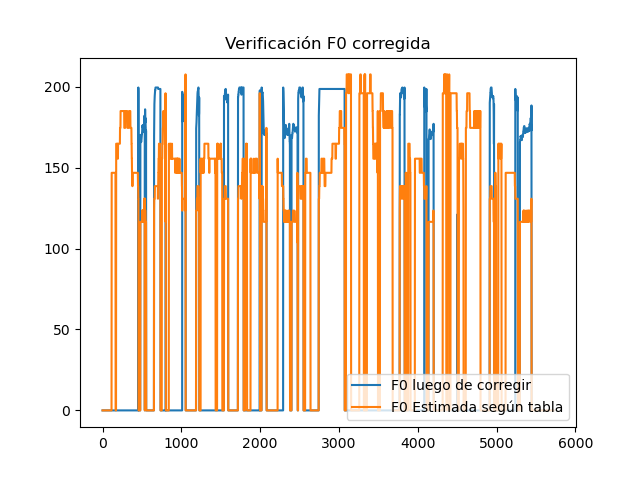

In [23]:
a,b = sc_wav.read('dataset_proyecto/vocadito_1.wav')
print('b', len(b))
alpha = 1.5
lala = pitchShift_alpha_cte(b, 1411, 256, alpha)

sc_wav.write('test_03.wav',44100, lala.astype(np.int16))

F0Corregida = estimarF0(lala, F0Ref)

fig, ax = plt.subplots()
ax.plot(F0Corregida, label = 'F0 luego de corregir')
ax.plot(F0EstimadaSegunTabla, label = 'F0 Estimada según tabla')
legend = ax.legend(loc='lower right')
plt.title('Verificación F0 corregida')
plt.show()

sc_wav.write('test_01.wav',rate,signalCorregida.astype(np.int16))
sc_wav.write('test_02.wav',rate,signal.astype(np.int16))
rate2, senal2 = sc_wav.read('test_01.wav')


In [12]:
a,b = sc_wav.read('dataset_proyecto/vocadito_1.wav')
print('b', len(b))
alpha = 0.8
lala = pitchShift(b, 1411, 256, alpha)

sc_wav.write('test_03.wav',44100, lala.astype(np.int16))

# lala = np.interp(np.arange(0, (len(lala) - 1)+alpha, alpha), np.arange(0, len(lala)), lala)
# print('lala', len(lala))
# sc_wav.write('test_04.wav', 44100, lala.astype(np.int16))


b 1464660
cant frames 5718


Estimar F0 del resultado

5722


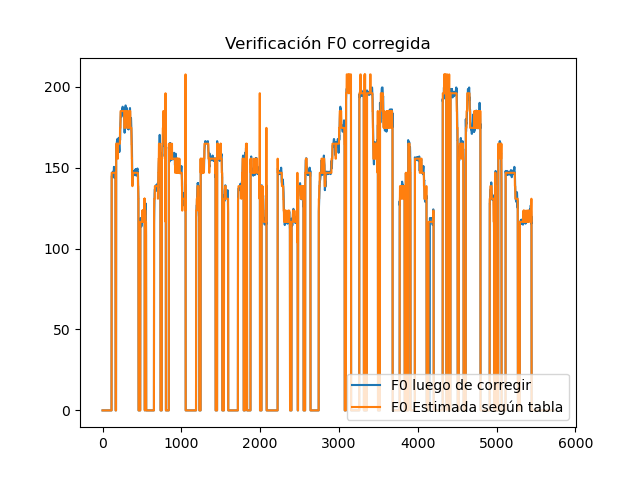

In [15]:
F0Corregida = estimarF0(lala, F0Ref)

fig, ax = plt.subplots()
ax.plot(F0Corregida, label = 'F0 luego de corregir')
ax.plot(F0EstimadaSegunTabla, label = 'F0 Estimada según tabla')
legend = ax.legend(loc='lower right')
plt.title('Verificación F0 corregida')
plt.show()

sc_wav.write('test_01.wav',rate,signalCorregida.astype(np.int16))
sc_wav.write('test_02.wav',rate,signal.astype(np.int16))
rate2, senal2 = sc_wav.read('test_01.wav')

Intento de shifteo por ventanas (day)

In [ ]:
rate, signal = sc_wav.read('dataset_proyecto/vocadito_1.wav')

tvent = 0.032
tstep = 0.005804988662131519

tamanioVent = int(tvent*rate)
nstep = int(tstep*rate)

cantidadVentanasRef = len(F0Ref)

ini = tamanioVent//2
vent = np.hamming(tamanioVent)

salida,numberFramesInput = createFrames(signal[ini:ini + tamanioVent]*vent,256,64)
salida2 = fusionFrames(salida,round(256*64))

salida=np.zeros((5713,1536))

for i in range(5713):
    
   #problema: distintos alfas dan distintos len en la interpolacion
    salida[i,:] = pitchShift(signal[ini:ini + tamanioVent]*vent,256,64,ratio[i])
    ini = ini + nstep    


# Para que la salida pueda tener distinta magnitud (y dsp hacer el 0padding o lo q sea)

#salida = []

#for i in range(5713):
#    print(i)
#   #problema: distintos alfas dan distintos len en la interpolacion
#    salida.append(pitchShift(signal[ini:ini + tamanioVent]*vent,256,64,ratio[i])) 
#    ini = ini + nstep